# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые перешли на тарифы («Ультра» или «Смарт»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится, она проводилась на курсе «Статистический анализ данных».

Необходимо построить модель с максимально большим значением *accuracy*. Задача - довести долю правильных ответов по крайней мере до 0.75 и проверить значение *accuracy* на тестовой выборке.

### **План работы:**
1. Подготовка - импортируем необходимые библиотеки, подготовим несколько функций, изучим файл, посмотрим на признаки
2. Разобьём данные на выборки
3. Исследуем некоторые модели и соберём результаты исследования в небольшую сводную таблицу
4. Проверим выбранную лучшую модель на естовых данных
5. Проверим модель на адекватность
6. Подведём общий итог проделанной работе

в работе не весь код собран в одном месте по классам или функциям. Хоть работу и можно было сделать "аккуратнее" убрав похожие друг на друга блоки кода (иногда они такими только кажутся), но не сделано это вполне осознанно, т.к. у нас исследовательская работа, соответствнно, лучше код иметь поближе к рассуждениям о нём - так его проще экспериментально покрутить-повертеть-поломать-починить

_____

## Откроем и изучим файл:

Импортируем все нужные нам библиотеки и модули:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 1000)

import matplotlib.pyplot as plt
from joblib import dump, load

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, 
                             recall_score, roc_auc_score, roc_curve)

import warnings
warnings.filterwarnings('ignore') # для итераций на LogisticRegression

Техническая часть - напишем три функции - две будут для отрисовки графиков и одна для будущей сводной таблицы

Плюс сохраним в переменную значение ```random_state```, чтоб по 100 раз его не повторять, так как значение будет везде одинаковым

In [2]:
def get_plot(model, accuracy_list_train, accuracy_list_valid, dot, best_accuracy, xlabel='', bias=1):
    '''функция для отрисовки plt.plot'''
    
    plt.figure(figsize=(12, 5))
    plt.plot(accuracy_list_train, label='train', c='#9308E8')
    plt.plot(accuracy_list_valid, label='valid', c='#027DF8')
    plt.scatter(dot-bias, best_accuracy, c='#02F83A', ec='#111113', s=50)
    plt.annotate(f'{best_accuracy=:.4f}', xy=(dot, best_accuracy),
                 xytext=(-16, 10), textcoords='offset points', fontweight='bold')

    plt.legend(facecolor='oldlace', edgecolor='#7B6DA5', loc='center right')
    plt.title(f'модель {type(model).__name__}', fontweight='bold', fontsize=15,  fontname='Arial')
    plt.xlabel(xlabel)
    plt.ylabel('значение accuracy')
    plt.xticks(range(len(accuracy_list_valid)), range(1, len(accuracy_list_valid)+1), rotation=90)     
    plt.minorticks_on()
    plt.grid(which='major', linewidth=0.5)
    plt.grid(which='minor', axis='y', linewidth=0.25, linestyle='--');  
    
    
def get_roc_curve(y, y_pred):
    '''функция для подсчёта AUC и отрисовки ROC-кривой'''
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    # Вычисляем AUC
    auc = roc_auc_score(y, y_pred)
    # Строим ROC-кривую
    plt.figure(figsize=(11, 5))
    plt.plot(fpr, tpr, c='#6C3483', label=f'AUC={auc:.3f}')
    plt.plot([0, 1], [0, 1], '--', color='#2C3E50')
    plt.xlabel('FPR - False Positive Rate')
    plt.ylabel('TPR - True Positive Rate')
    plt.title('ROC-кривая', fontweight='bold', fontsize=15,  fontname='Arial')
    plt.legend()
    plt.grid(linewidth=0.25, linestyle='--');

    
def get_table(best_model, best_accuracy, precision, recall):
    '''функция собираем название модели и переданные ей признаки'''
    
    return pd.DataFrame({'модель': [type(best_model).__name__], 
                         'best_accuracy': [best_accuracy], 
                         'precision': [precision], 
                         'recall': [recall],
                         'параметры': [f'{best_model=}']})
random_state = 47

Качаем датасет:

In [3]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('https://___')

Проверим, что в нём:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


Такие у нас есть признаки:

- **```calls```** - количество звонков, тип float
- **```minutes```** - суммарная длительность звонков в минутах, тип float
- **```messages```** - количество sms-сообщений, тип float
- **```mb_used```** - израсходованный интернет-трафик в Мб, тип float
- **```is_ultra```** - каким тарифом пользовались в течение месяца («Ультра» — 1, «Смарт» — 0), тип int - это целевой категориальный признак

In [6]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Подозрительно смотрятся количество звонков и смс типа *float*, поменяем на *int*:

In [7]:
df[['calls', 'messages']] = df[['calls', 'messages']].astype(int)

Посмотрим на целевой признак:

In [8]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Задача нам предстоит бинарной классификации, так как есть целевой признак, а значит будем применять алгоритмы обучения с учителем, считать ```accuracy``` и выбирать модель, показывающую лучший результат. 

И хоть метрика ```accuracy``` не сильно подходит в ситуациях с большим дисбалансом между классами (как у нас сейчас), задача именно такая, какая есть. $\Rightarrow$ помимо ```accuracy``` будем приглядываться и к ```precision``` с ```recall```

_____

## Разобьём данные на выборки

Разбиваем данные на *train*, *valid* и *test* в соотношении 3:1:1, с применением стратификации при разбиении, это позволит нам сохранить баланс классов в каждой выборке.

In [9]:
# бьём на train и test
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='is_ultra'), df['is_ultra'], test_size=.4, random_state=random_state, stratify=df['is_ultra'])

# и разбиваем test пополам -  на test и valid. Они будуи составлять по 20% от df
X_test, X_valid, y_test, y_valid = train_test_split(
    X_test, y_test, test_size=.5, random_state=random_state, stratify=y_test)

Посмотрим размеры:

In [10]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((1928, 4), (1928,), (643, 4), (643,), (643, 4), (643,))

In [11]:
print(f'доля X_test = {X_test.shape[0]/df.shape[0]:.2%}')

доля X_test = 20.01%


Проверим соотношение классов, оно должно быть в равных пропорциях:

In [12]:
y_train.value_counts(), y_valid.value_counts(), y_test.value_counts()

(0    1337
 1     591
 Name: is_ultra, dtype: int64,
 0    446
 1    197
 Name: is_ultra, dtype: int64,
 0    446
 1    197
 Name: is_ultra, dtype: int64)

Признаки у нас разного масштаба, а некоторые алгоритмы чувствительны к этому $\Rightarrow$ применим к данными стандартизацию и будем использовать стандартизированные признаки в работе тех алгоритмов, для которых это важно: 

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

_____

## Исследуем модели

Переберём несколько алгоритмов классификации, посмотрим на их работу с разными гиперпараметрами, по итогу выберем лучшие варианты от каждого алгоритма:

### начнём с LogisticRegression

,модель,best_accuracy,precision,recall,параметры
0,LogisticRegression,0.74339,0.758065,0.238579,"best_model=LogisticRegression(max_iter=8, random_state=47)"


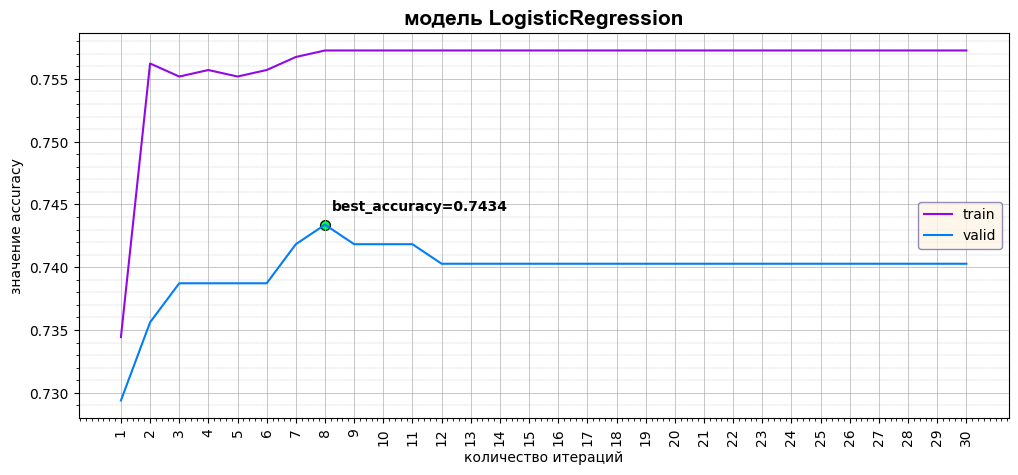

In [14]:
accuracy_list_train, accuracy_list_valid = [], []
best_accuracy, best_model, dot = 0, 0, 0

for i in range(1, 31):
    model = LogisticRegression(random_state=random_state, max_iter=i)
    model.fit(X_train_scaled, y_train)
    train_score = accuracy_score(y_train, model.predict(X_train_scaled))
    valid_score = accuracy_score(y_valid, model.predict(X_valid_scaled))
    accuracy_list_train.append(train_score)
    accuracy_list_valid.append(valid_score)
    if best_accuracy < valid_score:
        best_accuracy = valid_score
        best_model = model
        dot = i
precision = precision_score(y_valid, best_model.predict(X_valid_scaled))
recall = recall_score(y_valid, best_model.predict(X_valid_scaled))

logistic_model = get_table(best_model, best_accuracy, precision, recall)
display(logistic_model)

get_plot(model, accuracy_list_train, accuracy_list_valid, dot, best_accuracy, xlabel='количество итераций')

Алгоритм логистической регрессии ```LogisticRegression``` прогнозирует вероятность принадлежности объекта к одному из двух классов, минимизируя ошибку классификации на обучающих данных, и на основании полученной вероятности относит объекты к одному из классов. По умолчанию порог отсечки = 0.5

Алгоритм итерационный, он останавливает свою работу при получении минимального значения функции потерь *LogLoss* между векторами весов *w*. Наш алгоритм остановился уже после 12-й итерации (на нестандартизированных данных это была где-то 75-я итерация)

$accuracy = 0.743$

Главное примущество алгоритма - скорость, ответ мы получили практически мгновенно

### DecisionTreeClassifier - дерево решений

,модель,best_accuracy,precision,recall,параметры
0,DecisionTreeClassifier,0.799378,0.736111,0.538071,"best_model=DecisionTreeClassifier(max_depth=11, random_state=47)"


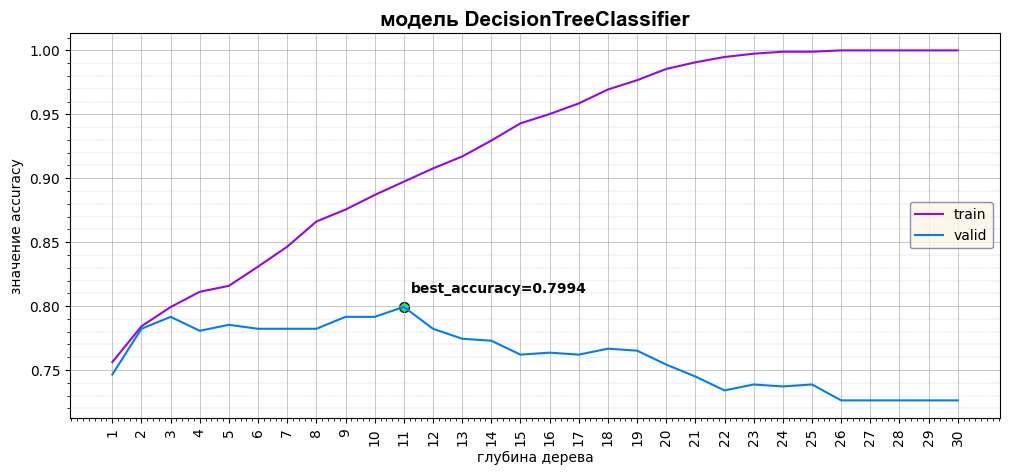

In [15]:
accuracy_list_train, accuracy_list_valid = [], []
best_accuracy, best_max_depth, best_model = 0, 0, 0

for depth in range (1, 31):
    model = DecisionTreeClassifier(max_depth=depth, random_state=random_state)
    model.fit(X_train, y_train)
    train_score  =  accuracy_score(y_train, model.predict(X_train)) 
    valid_score = accuracy_score(y_valid, model.predict(X_valid))
    accuracy_list_train.append(train_score)
    accuracy_list_valid.append(valid_score)
    if best_accuracy < valid_score:
        best_accuracy = valid_score
        best_max_depth = depth
        best_model = model
precision = precision_score(y_valid, best_model.predict(X_valid))
recall = recall_score(y_valid, best_model.predict(X_valid))
        
decisiontree_model = get_table(best_model, best_accuracy, precision, recall)
display(decisiontree_model)

get_plot(model, accuracy_list_train, accuracy_list_valid, best_max_depth, best_accuracy, xlabel='глубина дерева')

```DecisionTreeClassifier``` - алгоритм классификации, основанный на работе решающего дерева. Решающее дерево - это дерево, в котором каждый узел представляет тест на значение одного из признаков. Каждое ребро выходит из узла и соответствует возможному значению этого признака. В конечных узлах дерева (листьях или регионах) находятся метки классов.

Работу алгоритма ```DecisionTreeClassifier``` можно останавливать по множеству настраиваемых критериев останова, таких как:
- ограничение максимальной глубины дерева
- ограничение максимального количества листьев
- ограничение максимального количества n-объектов в листе
- остановка в случае, если все объекты в листе оказались одного класса
- и даже откат назад при недостаточном качестве разбиения на какую-то минимальную величину n-объектов

Алгоритм высчитывает в листьях вероятность принадлежности объекта к одному из классов (здесь это называется степенью уверенности) и на основании своей структуры делает предсказание для новых объектов. Если ```DecisionTreeClassifier``` никак не ограничивать, то дерево научится максимально точно предсказывать значения тренировочных данных и потеряет возможность адекватно предсказывать метки новых приходящих к нему признаков, т.о. случится *переобучение* (overfitting). Именно его мы можем видеть на графике выше - с увеличением количества деревьев значение accuracy на тренировочных данных постоянно растёт, тогда как на валидационных данных оно падает. Заберём себе лучшее значение *accuracy* из полученных - это: 

$accuracy = 0.799$

### RandomForestClassifier - случайный лес

,модель,best_accuracy,precision,recall,параметры
0,RandomForestClassifier,0.816485,0.772414,0.568528,"best_model=RandomForestClassifier(max_depth=20, min_samples_split=20, n_estimators=10,\n random_state=47)"


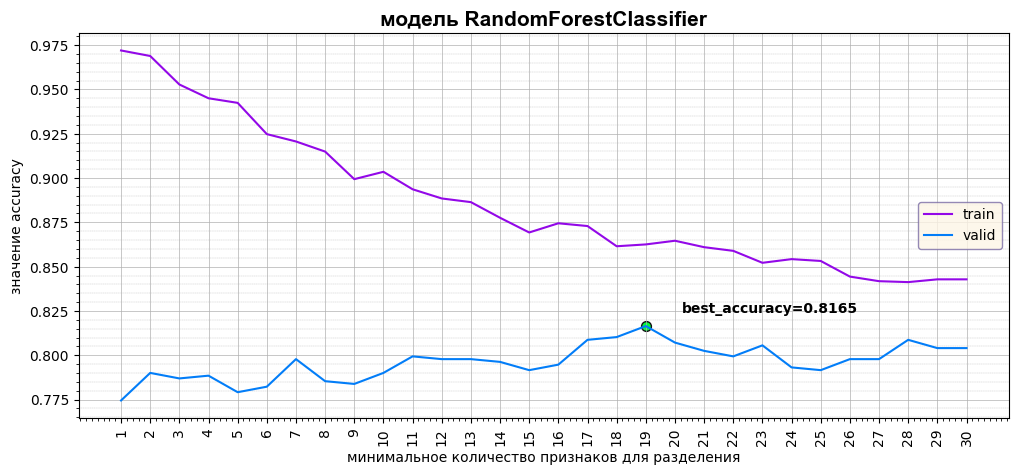

In [16]:
best_valid_scores = []
best_accuracy, best_max_depth, best_n_estimators, best_model, best_split = 0, 0, 0, 0, 0

for est in range(10, 51, 100):
    for depth in range (1, 31):
        accuracy_list_train, accuracy_list_valid = [], []
        for split in range(2, 32):
            model = RandomForestClassifier(max_depth=depth, n_estimators=est, 
                                           min_samples_split=split, random_state=random_state)
            model.fit(X_train, y_train)
            train_score  =  accuracy_score(y_train, model.predict(X_train)) 
            valid_score = accuracy_score(y_valid, model.predict(X_valid))
            accuracy_list_train.append(train_score)
            accuracy_list_valid.append(valid_score)
            if best_accuracy < valid_score:
                best_accuracy = valid_score
                best_max_depth = depth
                best_n_estimators = est
                best_model = model
                best_split = split
        best_valid_scores.append((best_accuracy, accuracy_list_train, accuracy_list_valid))

# для графика оставляем только проход с максимальным значением best_accuracy
best_accuracy, best_train_scores, best_valid_scores = max(best_valid_scores, key=lambda x: x[0])
        
precision = precision_score(y_valid, best_model.predict(X_valid))
recall = recall_score(y_valid, best_model.predict(X_valid))
            
randomforest_model = get_table(best_model, best_accuracy, precision, recall)
display(randomforest_model)

get_plot(model, best_train_scores, best_valid_scores, 
         best_max_depth, best_accuracy, xlabel='минимальное количество признаков для разделения', bias=2)

```RandomForestClassifier``` - это одна из разновидностей "деревянных" алгоритмов, использующих в своей основе ту же логику разбиения на узлы и листья, что и ```DecisionTree```-алгоритмы, только конечное решение здесь принимается не просто на основании степени уверенности одного какого-либо дерева, а производится т.н. *голосование деревьев*, так как в алгоритме их может быть много. 

Настройки гиперпараметров деревьев в лесу такие же разнообразные, как и для одного дерева, и все они могут влиять на конечный результат предсказания. 

Главное преимущество ```RandomForestClassifier``` в том, что каждое дерево строится на основе случайной подвыборки объектов и случайной подвыборки признаков, что сводит практически на нет *переобучение*, снижает проблему разброса данных (которой болеют деревья - это когда при незначительном изменении входных данных получается совсем другое дерево) и в целом улучшает обобщающую способность модели. Для наших данных *accuracy*:

$accuracy = 0.816$

мы итерационно пробовали менять количество деревьев, их глубину и минимальное количество признаков, необходимое для разделения узла. Лучшее значение accuracy достигнуто на 20-ти деревьях при глубине = 20 и минимальном количестве признаков=10. При дальнейшем их увеличении accuracy на тренировочных данных падает, тогда как на валидационных данных практически меняется слабо и так и останется балансировать где-то в диапазоне *accuracy* = 0.78-0.81

### GradientBoostingClassifier - градиантный бустинг

,модель,best_accuracy,precision,recall,параметры
0,GradientBoostingClassifier,0.819596,0.813953,0.532995,"best_model=GradientBoostingClassifier(max_depth=2, n_estimators=160, random_state=47)"


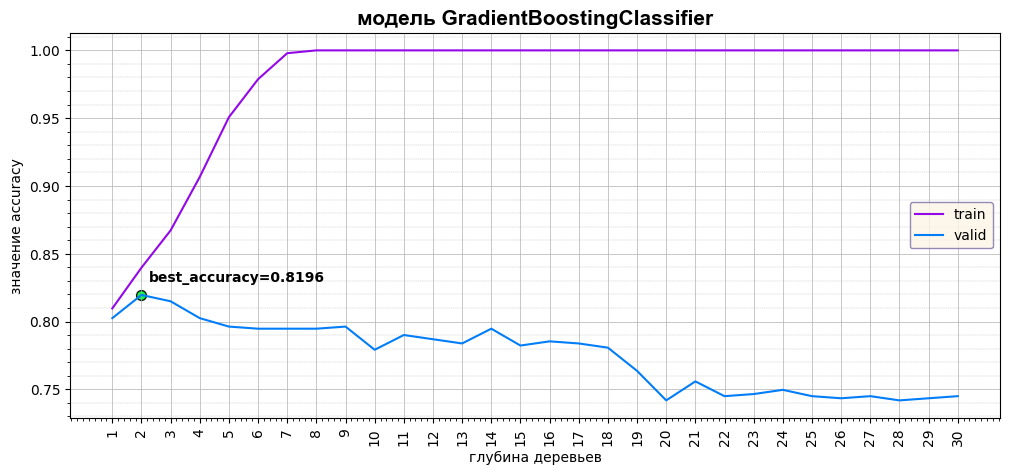

In [17]:
best_valid_scores = []
best_accuracy, best_max_depth, best_n_estimators, best_model = 0, 0, 0, 0

for est in range(10, 220, 50):
    accuracy_list_train, accuracy_list_valid = [], []
    for depth in range (1, 31):
        model = GradientBoostingClassifier(max_depth=depth, n_estimators=est, random_state=random_state)
        model.fit(X_train, y_train)
        train_score  =  accuracy_score(y_train, model.predict(X_train)) 
        valid_score = accuracy_score(y_valid, model.predict(X_valid))
        accuracy_list_train.append(train_score)
        accuracy_list_valid.append(valid_score)
        if best_accuracy < valid_score:
            best_accuracy = valid_score
            best_max_depth = depth
            best_n_estimators = est
            best_model = model
    best_valid_scores.append((best_accuracy, accuracy_list_train, accuracy_list_valid))
    
# для графика оставляем только проход с максимальным значением best_accuracy
best_accuracy, best_train_scores, best_valid_scores = max(best_valid_scores, key=lambda x: x[0])

precision = precision_score(y_valid, best_model.predict(X_valid))
recall = recall_score(y_valid, best_model.predict(X_valid))

gradientboosting_model = get_table(best_model, best_accuracy, precision, recall)
display(gradientboosting_model)

get_plot(model, best_train_scores, best_valid_scores, best_max_depth, best_accuracy, xlabel='глубина деревьев')

```GradientBoostingClassifier``` - это ещё одна разновидность ансамбля алгоритмов деревьев, но работает он не так, как RandomForest. Этот алгоритм забирает в себя все данные и не делит их на части, как лес. Первый алгоритм ансамбля (он может быть любым, не обязательно дерево) делает предсказание на данных и получает значение ошибки, а все последующие алгоритмы ансамбля (деревья) друг за другом пытаются предсказать (исправить) эту ошибку $\Rightarrow$ целевой переменной в работе алгоритма становится значение ошибки. Логика здесь такая, что *первое предсказание + его ошибка = значение целевого признака*

```GradientBoosting``` обычно работает лучше, чем одно дерево решений, но может занять гораздо больше времени на обучение, требует более тщательной настройки гиперпараметров и так же склонен к переобучению, что мы видим на графике - изменяя глубину деревьев и их количество в алгоритме значение accuracy на тренировочных данных довольно быстро приходит к единице, а на валидационных данных падает. В нашем случае лучшее значение *accuracy* получилось:

$accuracy = 0.819$

оно получено на ансамбле из 160-ти деревьев с глубиной = 2 (в ```GradientBoosting``` хорошие деревья часто такие вот "пеньки")

[![bagging_boosting.md.jpg](https://ltdfoto.ru/images/2023/03/29/bagging_boosting.md.jpg)](https://ltdfoto.ru/image/ig1vii)

### KNeighborsClassifier - классификация по соседям

,модель,best_accuracy,precision,recall,параметры
0,KNeighborsClassifier,0.799378,0.765625,0.497462,best_model=KNeighborsClassifier(n_neighbors=7)


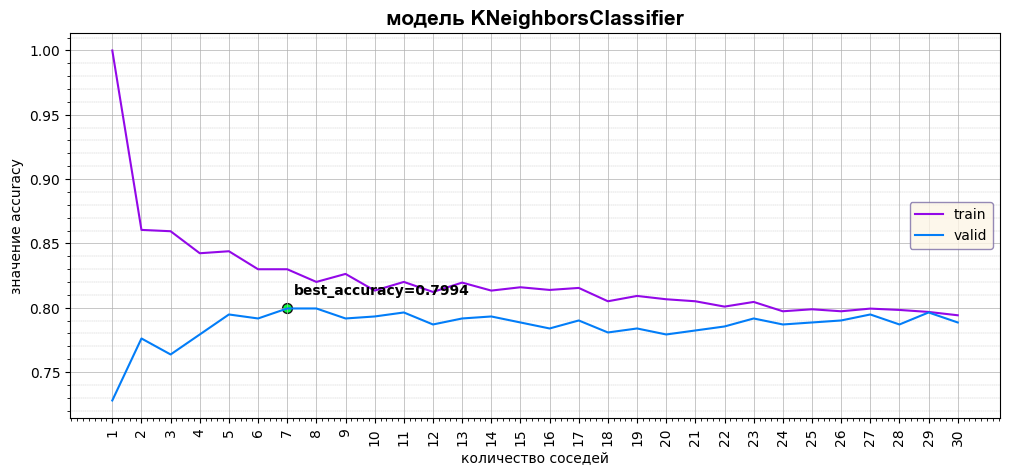

In [18]:
best_accuracy, best_n_neighbors, best_model = 0, 0, 0
accuracy_list_train, accuracy_list_valid = [], []

for i in range(1, 31):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_valid_scaled)
    
    train_score  =  accuracy_score(y_train, model.predict(X_train_scaled)) 
    valid_score = accuracy_score(y_valid, model.predict(X_valid_scaled))   
    accuracy_list_train.append(train_score)
    accuracy_list_valid.append(valid_score)
    
    if best_accuracy < valid_score:
        best_accuracy = valid_score
        best_n_neighbors = i
        best_model = model
precision = precision_score(y_valid, best_model.predict(X_valid_scaled))
recall = recall_score(y_valid, best_model.predict(X_valid_scaled))

kneighbors_model = get_table(best_model, best_accuracy, precision, recall)
display(kneighbors_model)

get_plot(model, accuracy_list_train, accuracy_list_valid, best_n_neighbors, best_accuracy, xlabel='количество соседей')

```KNeighborsClassifier``` - этот алгоритм относится к семейству алгоритмов "ленивого" обучения (lazy learning), так как фактически не требует фазы обучения и только хранит обучающие данные. Этим он похож на алгоритмы без учителя, однако к ним не относится, так как всё же требует наличия размеченных данных для обучения. 

Алгоритм находит заданное ему *k*-количество соседей в пространстве признаков и классифицирует рассматриваемый объект на основе классов его ближайших соседей. Именно поэтому для ```KNeighborsClassifier``` важно предварительно отмасштабировать данные, что мы и сделали. Далее в цикле меняли количество соседей и вот какую интересную картинку получили:

$accuracy = 0.799$

*accuracy* на валидационных данных достигает "локтя" после 5-ти соседей и далее практически не меняется, а вот на тренировочных данных значение *accuracy* падает, что очень логично, так как с увеличением площади для поиска соседей алгоритм теряет точность и всё больше превращается в случайное угадывание с вероятностью 1/2. Исправить падение на трейне можно добавлением гиперпараметра *weights='distance'* и тогда каджому признаку будет присвоен некий вес на основе его отдалённости от исследуемого объекта. При *weights='distance' accuracy* на тренировочных данных будет всегда = 1, а вот валидационным данным это особо не помогает. 

### соберём полученный данные в одну сводную таблицу

In [19]:
(
    pd.concat([logistic_model, decisiontree_model, randomforest_model, gradientboosting_model, kneighbors_model],
              axis=0).round(4).sort_values(by='best_accuracy', ascending=False).reset_index(drop=True)
)

,модель,best_accuracy,precision,recall,параметры
0,GradientBoostingClassifier,0.8196,0.8140,0.5330,"best_model=GradientBoostingClassifier(max_depth=2, n_estimators=160, random_state=47)"
1,RandomForestClassifier,0.8165,0.7724,0.5685,"best_model=RandomForestClassifier(max_depth=20, min_samples_split=20, n_estimators=10,\n random_state=47)"
2,DecisionTreeClassifier,0.7994,0.7361,0.5381,"best_model=DecisionTreeClassifier(max_depth=11, random_state=47)"
3,KNeighborsClassifier,0.7994,0.7656,0.4975,best_model=KNeighborsClassifier(n_neighbors=7)
4,LogisticRegression,0.7434,0.7581,0.2386,"best_model=LogisticRegression(max_iter=8, random_state=47)"


По таблице видим, что лучшее значение *accuracy* мы получили с использованием алгоритма ```GradientBoostingClassifier``` при максимальной глубине деревьев=2 и количестве деревьев в ансаибле=160. 

Плюс у этой модели *precision*=81%, что говорит в её пользу в сравнении с моделью ```RandomForestClassifier```, у которой значение *accuracy* тоже высокое, но ниже  *precision*. 

*precision*=81% говорит о том, что её точность модели ```GradientBoostingClassifier``` в предсказании тарифа "Ультра" составляет 81%, а *recall*=53% показывает долю правильных предсказаний от всех истинных.

Любые метрики необходимо рассматривать исходя из условия задачи, и хоть мы ищем лучшее значение *accuracy*, про *precision* и *recall* забывать не стоит $\Rightarrow$ модель на основе ```GradientBoostingClassifier``` должна нам подойти.

_____

## Проверим модель на тестовой выборке

In [20]:
best_model = GradientBoostingClassifier(max_depth=2, n_estimators=160, random_state=random_state)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

get_table(best_model, accuracy, precision, recall)

,модель,best_accuracy,precision,recall,параметры
0,GradientBoostingClassifier,0.822706,0.842975,0.517766,"best_model=GradientBoostingClassifier(max_depth=2, n_estimators=160, random_state=47)"


Очень даже неплохой результат! Лучше, чем на валидационных данных! Сохраним полученную модель:

In [21]:
dump(best_model, 'best_model.joblib')

#loaded_model = load('best_model.joblib')

['best_model.joblib']

_____

## Проверим модель на адекватность

```Sanity Check``` - оценка адекватности модели, проведём три популярные оценки:

**1. Baseline**

Если наша модель не предсказывает, а даёт простое наивное предположение, выбирая наиболее часто встречающийся класс, то доля правильных ответов должна быть такой:

In [22]:
df['is_ultra'].value_counts()[0] / df.shape[0]

0.693528313627878

У нас же эта доля такая:

In [23]:
accuracy

0.8227060653188181

**2. ROC-кривая**

```ROC-кривая``` позволяет оценить, насколько хорошо модель разделяет классы. Если значение площади под ROC-кривой (```AUC```) меньше 0.5, то модель работает хуже, чем случайная выборка:

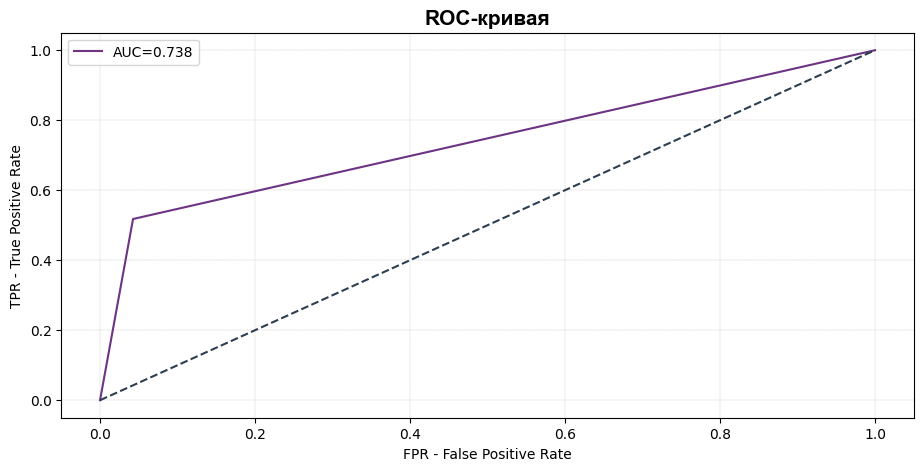

In [24]:
get_roc_curve(y_test, y_pred)

наше значение выше :)

**3. Cross-validation**

Не так уж прям проверка, но всё же. ```Кросс-валидация``` предполагает разбиение данных на выбранное количество "подвыборок"-фолдов и на разных итерациях постоянно меняется, за счёт этого мы получаем несколько замеров качества. 

Такой подход не только даёт нам больше уверенности в выборе модели, но он так же позволяет определить, насколько наша модель стабильна:  

In [25]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=8, scoring='accuracy')
print(f'{np.mean(cv_scores)=:.4f}\n{np.std(cv_scores)=:.4f}')

np.mean(cv_scores)=0.7993
np.std(cv_scores)=0.0142


Отклонение от среднего небольшое и это говорит нам о том, что модель ```GradientBoostingClassifier``` довольно стабильна, её не кидает из стороны в сторону и на разных фолдах, значение *accuracy* в целом похожи, а значит выбранной нами модели можно доверять.

$\Rightarrow$ после трёх проверок на адекватность (плюс ранее анализировали *precision* и *recall*) мы можем сделать вывод о том, что выбранная нами модель адекватная и вполне себе рабочая, она подходит для нашей задачи бинарной классификации

_____

## Общий вывод:

В данной исследовании мы рассмотрели работу алгоритмов классификации для определения оптимальной модели, которая будет выбирать подходящий тариф («Ультра» или «Смарт»). Мы выбрали для анализа следующие алгоритмы:
- GradientBoostingClassifier
- RandomForestClassifier	
- DecisionTreeClassifier
- KNeighborsClassifier
- LogisticRegression	

Метрики, которые мы оценивали:
- accuracy
- precision
- recall
- AUC-score

в результате исследования для формирования модели был выбран следующий алгоритм:
- GradientBoostingClassifier(max_depth=2, n_estimators=160, random_state=47)

Он показал следующие лучшие значения метрики *accuracy*:
- на train-выборке: 0.83973
- на valid-выборке: 0.819596
- на test-выборке: 0.822706

Выбранную модель проверили на адекватность с помощью:
- метода Baseline
- площади под ROC-кривой
- кросс-валидации на 8-ми фолдах

По итогу исследования решено оставить модель, основанную на ```GradientBoostingClassifier``` как наилучшую.

P.S.: для исследования мы перебирали параметры вручную, фактически изобретая велосипед с циклами, что здорово, но не оптимально, так как, на самом деле, велосипед для подбора гиперпараметров давно есть - это модуль ```GridSearchCV``` из библиотеки ```sklearn.model_selection```, вот пример его применения:

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 
              'metric': ['euclidean', 'manhattan']}
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

best_clf = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')
best_clf.fit(X_train_scaled, y_train)

accuracy_score(y_valid, best_clf.predict(X_valid_scaled)) 

{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.8023739990579368


0.7993779160186625

но мы, проделав процедуру подбора параметров "вручную", смогли не только лучше разобраться в представленных алгоритмах и принципах их работы, но так же графиков красивых понастроили)) так что работа проделана не зря. 